In [1]:
class CFG:
    model = 'microsoft/deberta-v3-large'

In [2]:
import os
import glob
import re

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm

import torch
print(f'torch.__version__: {torch.__version__}')
from torch.utils.data import DataLoader, Dataset
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

torch.__version__: 1.11.0
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


In [3]:
INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'../output/'

In [4]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [5]:
# anchorがtargetに含まれているかどうかをみる
train['intersection'] = train.apply(lambda row: row['anchor'] in row['target'], axis=1)
print(f"{train['intersection'].sum() / len(train):.4f} % targets include their anchors.")
train.head()

0.0566 % targets include their anchors.


,id,anchor,target,context,score,intersection
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,True
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,False
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,False
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,False
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,False


In [8]:
# ====================================================
# CPC Data
# ====================================================
# def get_cpc_texts():
#     contexts = []
#     pattern = '[A-Z]\d+'
#     for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
#         result = re.findall(pattern, file_name)
#         if result:
#             contexts.append(result)
#     contexts = sorted(set(sum(contexts, [])))
#     results = {}
#     for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
#         with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
#             s = f.read()
#         pattern = f'{cpc}\t\t.+'
#         result = re.findall(pattern, s)
#         cpc_result = result[0].lstrip(pattern)
#         for context in [c for c in contexts if c[0] == cpc]:
#             pattern = f'{context}\t\t.+'
#             result = re.findall(pattern, s)
#             results[context] = cpc_result + ". " + result[0].lstrip(pattern)
#     return results


# https://www.kaggle.com/code/lunapandachan/uspppm-eda-v3/notebook?scriptVersionId=95951164
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        df_cpc=pd.read_csv(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt', sep='\t',names=('seg','num','context'))
        cpc_result=df_cpc[df_cpc['seg']==cpc]['context'].values
#        print(cpc_result)
        for context in [c for c in contexts if c[0] == cpc]:
            result = df_cpc[df_cpc['seg']==context]['context'].values
            # con_text=str.lower(cpc_result[0]) + ". " + str.lower(result[0])
            con_text = cpc_result[0] + ". " + result[0]
            results[context] = con_text
    return results


cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,intersection,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,True,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,False,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,False,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,False,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,False,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [9]:
cpc_texts

{'A01': 'HUMAN NECESSITIES. AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTING; TRAPPING; FISHING',
 'A21': 'HUMAN NECESSITIES. BAKING; EDIBLE DOUGHS',
 'A22': 'HUMAN NECESSITIES. BUTCHERING; MEAT TREATMENT; PROCESSING POULTRY OR FISH',
 'A23': 'HUMAN NECESSITIES. FOODS OR FOODSTUFFS; TREATMENT THEREOF, NOT COVERED BY OTHER CLASSES',
 'A24': "HUMAN NECESSITIES. TOBACCO; CIGARS; CIGARETTES; SIMULATED SMOKING DEVICES; SMOKERS' REQUISITES",
 'A41': 'HUMAN NECESSITIES. WEARING APPAREL',
 'A42': 'HUMAN NECESSITIES. HEADWEAR',
 'A43': 'HUMAN NECESSITIES. FOOTWEAR',
 'A44': 'HUMAN NECESSITIES. HABERDASHERY; JEWELLERY',
 'A45': 'HUMAN NECESSITIES. HAND OR TRAVELLING ARTICLES',
 'A46': 'HUMAN NECESSITIES. BRUSHWARE',
 'A47': 'HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL',
 'A61': 'HUMAN NECESSITIES. MEDICAL OR VETERINARY SCIENCE; HYGIENE',
 'A62': 'HUMAN NECESSITIES. LIFE-SAVING; FIRE-FIGHTING',
 'A63': 'HUMAN NECESSITIES. S

In [9]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,intersection,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,True,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,False,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,False,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,False,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,False,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


In [10]:
train.iloc[0]['text']

'abatement[SEP]abatement of pollution[SEP]HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL'

<AxesSubplot:>

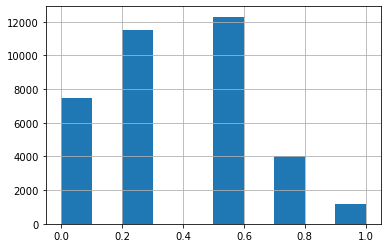

In [11]:
train['score'].hist()

In [12]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label